In [86]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [88]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

In [89]:
len(train_ds.data), len(train_ds.labels), len(eval_ds.data), len(eval_ds.labels)

(120809, 120809, 52270, 52270)

In [90]:

mapping = {}
rev_mapping = {}
for i, label in enumerate(set(train_ds.labels)):
    mapping[i] = label
    rev_mapping[label] = i
    
train_mapped_labels = [rev_mapping[label] for label in train_ds.labels]
eval_mapped_labels = [rev_mapping[label] for label in eval_ds.labels]

print(len(train_mapped_labels))

train_ds.labels = train_mapped_labels
eval_ds.labels = eval_mapped_labels

BATCH_SIZE = 16

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

120809


In [91]:
min(mapping.keys()), min(rev_mapping.keys()), max(mapping.keys()), max(rev_mapping.keys())

(0, 0, 909, 1309)

In [92]:
len(train_ds.labels), len(train_ds.data)

(120809, 120809)

In [93]:
# Check if shapes are ok
en1, en2 = train_ds[0], train_ds[5]

en1[0].shape, en2[0].shape

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]))

#### Set the train loop

In [94]:
loss_history = []
accuracy_history = []

def train(model, criterion, optimizer, train_loader, valid_loader, epochs, save_path="models/model"):
    best_val_loss = float('inf')  # Initialize with infinity
    
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)    
    
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        val_loss = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        loss_history.append(loss.item())    
        
        scheduler.step(val_loss)
        
        # Inspect the learning rate changes
        for param_group in optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']}")
        
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
                # Get accuracy
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        
        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)
        
        val_acc = 100 * (correct / total)
        
        accuracy_history.append(val_acc)
        
        print(f"Validation accuracy: {val_acc:0.3f}%")
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch+1}")
            print("Model saved with validation loss:", best_val_loss)


### 2. Get model and set it up

In [95]:
import os

model = models.resnet50(pretrained=True)
model = model.to(device)

n_features = model.fc.in_features
n_classes = train_ds.get_n_classes()

model.fc = nn.Linear(n_features, n_classes)

if os.path.exists("models/resnet50.pt"):
    model.load_state_dict(torch.load("models/resnet50.pt"))

model = model.to(device)

### 3. Train the model

In [96]:
LR = 1e-4

n_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [97]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, "models/resnet50.pt")

KeyboardInterrupt: 

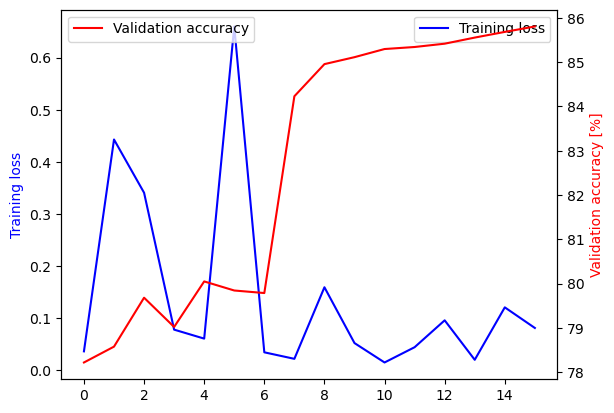

In [ ]:
import matplotlib.pyplot as plt

epoch_cutoff = 18

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()

# Plot data on the primary y-axis
ax1.plot(loss_history[:epoch_cutoff], color='blue', label='Training loss')
ax1.set_ylabel('Training loss', color='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data on the secondary y-axis
ax2.plot(accuracy_history[:epoch_cutoff], color='red', label='Validation accuracy')
ax2.set_ylabel('Validation accuracy [%]', color='red')

# Add legend
ax1.legend(loc='best')
ax2.legend(loc='best')

# Show plot
plt.show()